In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV

import utils.data
import utils.correlation


---------


# Classifier on Correlation Matrix

In [2]:
control_data = utils.data.batch_read('../data/Controls_columns')
prodomal_data = utils.data.batch_read('../data/Prodomals_columns')
parkinson_data = utils.data.batch_read('../data/PDs_columns')

> Selecting only BOLD timeseries from AAL3 atlas.

In [3]:
control_AAL3_data = utils.data.select_atlas_columns(control_data, 'AAL3')
prodomal_AAL3_data = utils.data.select_atlas_columns(prodomal_data, 'AAL3')
parkinson_AAL3_data = utils.data.select_atlas_columns(parkinson_data, 'AAL3')

control_AAL3_data[0].head()

,AAL3.cluster001,AAL3.cluster002,AAL3.cluster003,AAL3.cluster004,AAL3.cluster005,AAL3.cluster006,AAL3.cluster007,AAL3.cluster008,AAL3.cluster009,AAL3.cluster010,...,AAL3.cluster161,AAL3.cluster162,AAL3.cluster163,AAL3.cluster164,AAL3.cluster165,AAL3.cluster166,AAL3.cluster167,AAL3.cluster168,AAL3.cluster169,AAL3.cluster170
0,-0.060492,-0.064699,0.027009,0.006356,0.064636,0.025074,-0.072370,-0.023259,0.030439,0.141354,...,-0.128405,-0.212190,0.071778,-0.085851,-0.369906,-0.227215,0.218964,0.143408,0.114787,0.086331
1,0.004386,-0.048182,-0.005618,-0.001391,-0.028455,0.004416,0.008140,-0.016648,-0.002957,0.110977,...,0.121169,0.002904,0.144537,-0.160525,0.209921,0.348922,-0.037231,0.342327,0.182087,-0.142731
2,0.020226,-0.028979,-0.017380,0.002162,-0.063357,0.000866,0.041881,0.002447,-0.014558,0.048355,...,0.242692,0.082687,0.049029,-0.125446,0.396209,0.546062,-0.140805,0.501917,0.402791,-0.298033
3,-0.051301,-0.017008,0.021943,0.026391,0.032551,0.023242,-0.035161,0.014269,0.024234,-0.009537,...,0.064849,-0.150406,-0.138013,0.020100,-0.285842,-0.085880,0.057809,0.427078,0.668149,-0.168126
4,-0.096539,-0.009171,0.079801,0.052421,0.142671,0.025372,-0.122511,-0.020408,0.075939,-0.014011,...,-0.111373,-0.411528,0.032230,0.015906,-1.012333,-0.702678,0.194447,0.166741,0.575768,0.124174


> Building the Connectivity Matrix using Pearson Correlation

In [4]:
control_correlation_matrix = utils.correlation.pearson_correlation(control_AAL3_data)
prodomal_correlation_matrix = utils.correlation.pearson_correlation(prodomal_AAL3_data)
parkinson_correlation_matrix = utils.correlation.pearson_correlation(parkinson_AAL3_data)


> From the Connectivity matrix, we will use only the upper triangle to reduce redundancy. This is due to the fact that the matrix is symmetrical.

In [5]:
control_triu_data = utils.data.get_triu(control_correlation_matrix, k=1)
prodomal_triu_data = utils.data.get_triu(prodomal_correlation_matrix, k=1)
parkinson_triu_data = utils.data.get_triu(parkinson_correlation_matrix, k=1)

Getting upper triangle: 100%|██████████| 151/151 [00:00<00:00, 8123.80it/s]


In [16]:
X = utils.data.concatenate_data(control_triu_data, prodomal_triu_data, parkinson_triu_data)
y = utils.data.concatenate_data([0 for _ in range(len(control_data))], [1 for _ in range(len(prodomal_data))], [2 for _ in range(len(parkinson_data))])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)


----

## Baseline

In [23]:
print(f"Control Samples: {len(control_data)}    Prodomal Samples: {len(prodomal_data)}    Parkinson Samples: {len(parkinson_data)}")

Control Samples: 66    Prodomal Samples: 183    Parkinson Samples: 151


One way to build a baseline model for a imbalanced classification problem like this one is to assume every sample get classified as the majority class.

In [24]:
y_pred_baseline = [1 for _ in range(len(y_test))]

> Baseline Measurements to outperform: 

In [25]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline)}")
print(f"f1_score: {f1_score(y_test, y_pred_baseline, average='weighted')}")
print(f"precision_score: {f1_score(y_test, y_pred_baseline, average='weighted')}")
print(f"recall_score: {f1_score(y_test, y_pred_baseline, average='weighted')}")


Accuracy: 0.4625
f1_score: 0.2925213675213675
precision_score: 0.2925213675213675
recall_score: 0.2925213675213675


## Logistic Regression


In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
model = LogisticRegression(max_iter=2000, class_weight='balanced')


In [31]:
param_dist = {
    'C': np.logspace(-3, 3, 13),
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=cv, scoring='f1_macro', n_jobs=4, random_state=42)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=2000),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                                        'penalty': ['l2'],
                                        'solver': ['lbfgs', 'saga']},
                   random_state=42, scoring='f1_macro')

In [ ]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.500     0.154     0.235        13
           1      0.692     0.730     0.711        37
           2      0.541     0.667     0.597        30

    accuracy                          0.613        80
   macro avg      0.578     0.517     0.514        80
weighted avg      0.604     0.613     0.591        80

[[ 2  3  8]
 [ 1 27  9]
 [ 1  9 20]]


Text(0.5, 1.0, 'Matriz de Confusão')

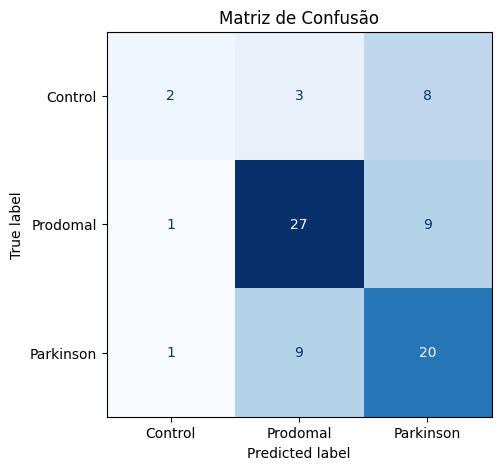

In [37]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf = RandomForestClassifier(class_weight='balanced')

In [40]:
param_dist = {
  'n_estimators': [100, 200, 500],
  'max_depth': [None, 5, 10, 20],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
}

In [48]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(rf, param_dist, cv=cv, scoring='f1_macro', n_jobs=8)
search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=8,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1_macro')

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        13
           1      0.532     0.676     0.595        37
           2      0.515     0.567     0.540        30

    accuracy                          0.525        80
   macro avg      0.349     0.414     0.378        80
weighted avg      0.439     0.525     0.478        80



/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/theoriffel/codes/IC/Parkinson-Diagnosis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Text(0.5, 1.0, 'Matriz de Confusão')

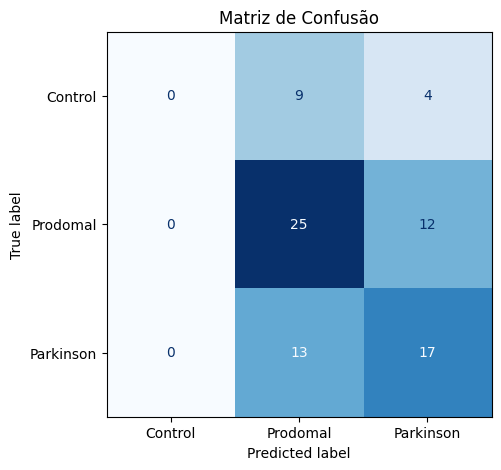

In [51]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Prodomal', 'Parkinson'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão")